In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('/content/sentiment_analysis.csv')
df.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


# **Text Preprocessing**

In [5]:
import re
import string

In [6]:
# convert texts to lower case
df['tweet'] = df['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [7]:
df['tweet'].head()

,tweet
0,#fingerprint #pregnancy test https://goo.gl/h1...
1,finally a transparant silicon case ^^ thanks t...
2,we love this! would you go? #talk #makememorie...
3,i'm wired i know i'm george i was made that wa...
4,what amazing service! apple won't even talk to...


In [8]:
# remove links
df['tweet'] = df['tweet'].apply(lambda x: " ".join(re.sub(r'^https?:\/\/.*[\r\n]*','',x, flags=re.MULTILINE) for x in x.split()))

In [9]:
df['tweet'].head()

,tweet
0,#fingerprint #pregnancy test #android #apps #...
1,finally a transparant silicon case ^^ thanks t...
2,we love this! would you go? #talk #makememorie...
3,i'm wired i know i'm george i was made that wa...
4,what amazing service! apple won't even talk to...


In [10]:
# remove puncuations
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [11]:
def remove_punctuation(text):
  for punctuation in string.punctuation:
    text = text.replace(punctuation,'')
  return text

df['tweet'] = df['tweet'].apply(remove_punctuation)
df['tweet'].head()

,tweet
0,fingerprint pregnancy test android apps beaut...
1,finally a transparant silicon case thanks to ...
2,we love this would you go talk makememories un...
3,im wired i know im george i was made that way ...
4,what amazing service apple wont even talk to m...


In [12]:
# remove numbers
df['tweet'] = df['tweet'].str.replace('\d+','', regex = True)
df['tweet'].head()

,tweet
0,fingerprint pregnancy test android apps beaut...
1,finally a transparant silicon case thanks to ...
2,we love this would you go talk makememories un...
3,im wired i know im george i was made that way ...
4,what amazing service apple wont even talk to m...


In [13]:
# remove stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stopwords.words('english')))
df['tweet'].head()

,tweet
0,fingerprint pregnancy test android apps beauti...
1,finally transparant silicon case thanks uncle ...
2,love would go talk makememories unplug relax i...
3,im wired know im george made way iphone cute d...
4,amazing service apple wont even talk question ...


In [15]:
# stemming
from nltk.stem import PorterStemmer
st = PorterStemmer()

In [16]:
df['tweet'] = df['tweet'].apply(lambda x: " ".join(st.stem(x) for x in x.split()))

In [17]:
df['tweet'].head()

,tweet
0,fingerprint pregnanc test android app beauti c...
1,final transpar silicon case thank uncl yay son...
2,love would go talk makememori unplug relax iph...
3,im wire know im georg made way iphon cute dave...
4,amaz servic appl wont even talk question unles...


# **Building Vocabulary**

In [18]:
from collections import Counter
vocab = Counter()

In [19]:
for sentence in df['tweet']:
  vocab.update(sentence.split())

In [20]:
len(vocab)

15949

Clearly the number of features is large compared to the number of records. There is a hight probability of this could affect in an overfit. Normally the the number of features should be less than the number of records.

In [21]:
tokens = [key for key in vocab if vocab[key]>10]

In [22]:
len(tokens)

1145

In [23]:
def save_vocabulary(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w', encoding="utf-8")
    file.write(data)
    file.close()

save_vocabulary(tokens, '/content/static.txt')

# **Divide the Dataset**

In [24]:
X = df['tweet']
y = df['label']

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# **Vectorization**

In [26]:
def vectorizer(ds, vocabulary):
  vectorized_lst = []

  for sentence in ds:
    sentence_lst = np.zeros(len(vocabulary))

    for i in range(len(vocabulary)):
      if vocabulary[i] in sentence.split():
        sentence_lst[i] = 1

    vectorized_lst.append(sentence_lst)

  vectorized_new_lst = np.asarray(vectorized_lst, dtype = np.float32)

  return vectorized_new_lst

In [27]:
vectorized_X_test = vectorizer(X_test, tokens)
vectorized_X_train = vectorizer(X_train, tokens)

In [28]:
y_train.value_counts()

,count
label,
0,4742
1,1594


There is a imbalance in the dataset

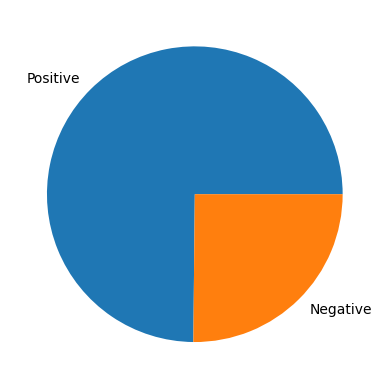

In [29]:
plt.pie(np.array([y_train.value_counts()[0], y_train.value_counts()[1]]), labels = ["Positive", "Negative"])
plt.show()

# **Handle Imbalance Data**

In [30]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
vectorized_X_train_smote, y_train_smote = smote.fit_resample(vectorized_X_train, y_train)
print(vectorized_X_train_smote.shape, y_train_smote.shape)

(9484, 1145) (9484,)


In [31]:
y_train_smote.value_counts()

,count
label,
0,4742
1,4742


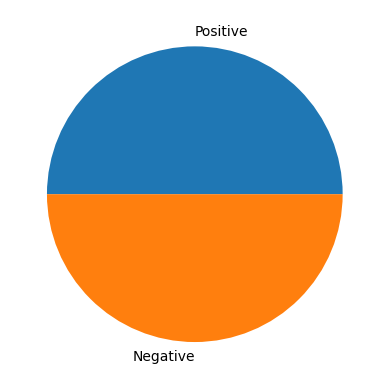

In [32]:
plt.pie(np.array([y_train_smote.value_counts()[0], y_train_smote.value_counts()[1]]), labels=['Positive', 'Negative'])
plt.show()

# **Model Training and Evaluation**

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [34]:
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score

def training_scores(y_act, y_pred):
  acc = round(accuracy_score(y_act, y_pred), 3)
  pr = round(precision_score(y_act, y_pred), 3)
  rec = round(recall_score(y_act, y_pred), 3)
  f1 = round(f1_score(y_act, y_pred), 3)
  print(f'Training Scores:\n\tAccuracy = {acc}\n\tPrecision = {pr}\n\tRecall = {rec}\n\tF1-Score = {f1}')

def validation_scores(y_act, y_pred):
    acc = round(accuracy_score(y_act, y_pred), 3)
    pr = round(precision_score(y_act, y_pred), 3)
    rec = round(recall_score(y_act, y_pred), 3)
    f1 = round(f1_score(y_act, y_pred), 3)
    print(f'Testing Scores:\n\tAccuracy = {acc}\n\tPrecision = {pr}\n\tRecall = {rec}\n\tF1-Score = {f1}')

# **Logistic Regression**

In [35]:
lr = LogisticRegression()
lr.fit(vectorized_X_train_smote, y_train_smote)

y_train_pred = lr.predict(vectorized_X_train_smote)

y_test_pred = lr.predict(vectorized_X_test)

training_scores(y_train_smote, y_train_pred)
validation_scores(y_test, y_test_pred)

Training Scores:
	Accuracy = 0.94
	Precision = 0.915
	Recall = 0.971
	F1-Score = 0.942
Testing Scores:
	Accuracy = 0.868
	Precision = 0.725
	Recall = 0.831
	F1-Score = 0.775


# **Naive Bayes**

In [36]:
mnb = MultinomialNB()
mnb.fit(vectorized_X_train_smote, y_train_smote)

y_train_pred = mnb.predict(vectorized_X_train_smote)

y_test_pred = mnb.predict(vectorized_X_test)

training_scores(y_train_smote, y_train_pred)

validation_scores(y_test, y_test_pred)

Training Scores:
	Accuracy = 0.907
	Precision = 0.871
	Recall = 0.955
	F1-Score = 0.911
Testing Scores:
	Accuracy = 0.882
	Precision = 0.726
	Recall = 0.91
	F1-Score = 0.808


# **Decision Tree**

In [37]:
dt = DecisionTreeClassifier()

dt.fit(vectorized_X_train_smote, y_train_smote)

y_train_pred = dt.predict(vectorized_X_train_smote)

y_test_pred = dt.predict(vectorized_X_test)

training_scores(y_train_smote, y_train_pred)

validation_scores(y_test, y_test_pred)

Training Scores:
	Accuracy = 1.0
	Precision = 1.0
	Recall = 0.999
	F1-Score = 1.0
Testing Scores:
	Accuracy = 0.843
	Precision = 0.72
	Recall = 0.697
	F1-Score = 0.708


# **Random Forest**

In [38]:
rf = RandomForestClassifier()

rf.fit(vectorized_X_train_smote, y_train_smote)

y_train_pred = rf.predict(vectorized_X_train_smote)

y_test_pred = rf.predict(vectorized_X_test)

training_scores(y_train_smote, y_train_pred)

validation_scores(y_test, y_test_pred)

Training Scores:
	Accuracy = 1.0
	Precision = 1.0
	Recall = 1.0
	F1-Score = 1.0
Testing Scores:
	Accuracy = 0.879
	Precision = 0.823
	Recall = 0.711
	F1-Score = 0.763


# **Support Vector Machine**

In [39]:
svm = SVC()

svm.fit(vectorized_X_train_smote, y_train_smote)

y_train_pred = svm.predict(vectorized_X_train_smote)

y_test_pred = svm.predict(vectorized_X_test)

training_scores(y_train_smote, y_train_pred)

validation_scores(y_test, y_test_pred)

Training Scores:
	Accuracy = 0.978
	Precision = 0.961
	Recall = 0.996
	F1-Score = 0.978
Testing Scores:
	Accuracy = 0.887
	Precision = 0.786
	Recall = 0.806
	F1-Score = 0.795


In [40]:
import pickle

model = lr

with open('model.pkl', 'wb') as file:
  pickle.dump(model, file)

In [41]:
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

In [45]:
def preprocessing(text):
    data = pd.DataFrame([text], columns=['tweet'])
    data["tweet"] = data["tweet"].apply(lambda x: " ".join(x.lower() for x in x.split()))
    data["tweet"] = data['tweet'].apply(lambda x: " ".join(re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE) for x in x.split()))
    data["tweet"] = data["tweet"].apply(remove_punctuations)
    data["tweet"] = data['tweet'].str.replace('\d+', '', regex=True)
    data["tweet"] = data["tweet"].apply(lambda x: " ".join(x for x in x.split() if x not in stopwords.words('english')))
    data["tweet"] = data["tweet"].apply(lambda x: " ".join(st.stem(x) for x in x.split()))
    return data["tweet"]

In [46]:
def get_prediction(vectorized_text):
    prediction = model.predict(vectorized_text)
    if prediction == 1:
        return 'negative'
    else:
        return 'positive'

In [50]:
txt = "awesome product. i love it"
preprocessed_txt = preprocessing(txt)
vectorized_txt = vectorizer(preprocessed_txt, tokens)
prediction = get_prediction(vectorized_txt)
prediction

'positive'